### Plot Computed PID Components (using Bertschinger)

PID Component values for each class of discrete function are pre-computed and included in a subfolder

This loads and plots them as in Figure 6 of the paper

See the other notebook "make_Q_plots" for details on how to perform the actual computation for a given function

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
from copy import copy
from tqdm import tqdm_notebook as tqdm

def entropy(Fp,Hix):
    Hnot=tuple({0,1,2}-Hix)
    Fsum=np.sum(Fp,axis=Hnot)
    return -np.nansum(Fsum*np.log(Fsum))
  
def dgps(Fp):
    Hi=np.array([entropy(Fp,{i}) for i in range(3)])
    Hij=np.array([entropy(Fp,{0,1,2}-{i}) for i in range(3)])
    HijHjk=np.sum(Hij)-Hij
    Hijk=entropy(Fp,{0,1,2})
    omega=np.sum(Hi)-Hijk
    delta=(-Hi+HijHjk-Hijk)/omega
    Hall={'Hi':Hi,'Hij':Hij,'Hijk':Hijk}
    return delta,omega,Hall

In [2]:
from glob import glob
D=[]
PID=[]
Zlist=[]
for f in glob('./bertschinger_results/*.npy'):
    k=int(f.split('/')[-1].split('.')[0])
    pid=np.load(f)
    Z=pid[:-4].astype(int)
    pid=pid[-4:]
    
    a=3

    ix=np.array([[k for k in range(a)]]*a)
    x=ix.ravel(order='F')
    y=ix.ravel(order='C')
    p=np.zeros((a,a,a))
    p[x,y,Z]=1.0
    p=p/np.sum(p)
    d,o,_=dgps(p)
    
    D.append(d)
    PID.append(pid)
    Zlist.append(Z)
D=np.vstack(D).T
PID=np.vstack(PID).T
Zlist=np.vstack(Zlist)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


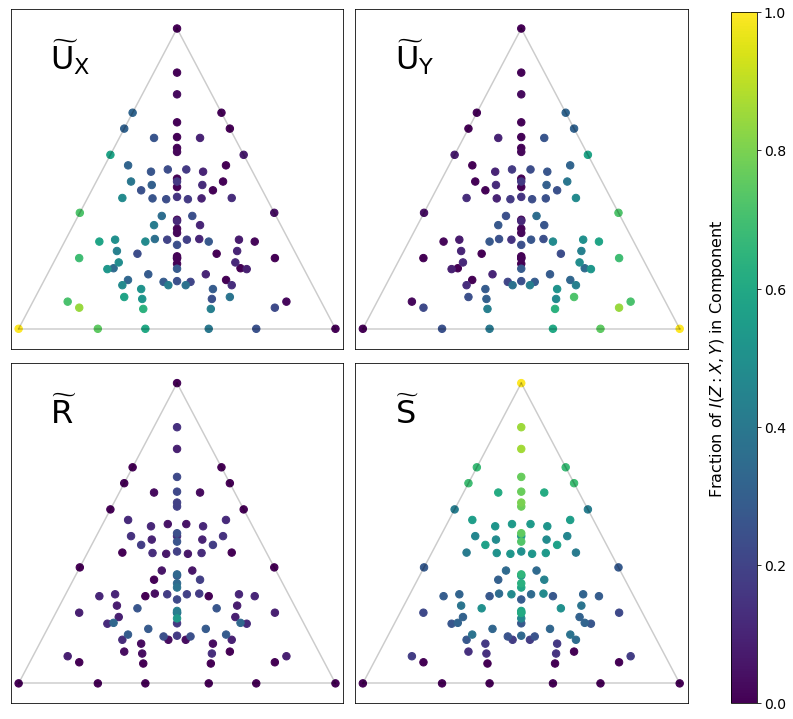

In [5]:
labels=['$\mathrm{\widetilde{U}_X}$','$\mathrm{\widetilde{U}_Y}$','$\mathrm{\widetilde{R}}$','$\mathrm{\widetilde{S}}$']
fig=plt.figure(figsize=(12,10))
ax=[]
for k in range(4):
    ax.append(plt.subplot(2,2,k+1))

    #ax[-1].set_axis_off()
    x=D[0]-D[1]
    y=(D[0]+D[1]+2*D[2])/4
    z=PID[k]/PID.sum(0)
    #z=PID[k]

    ix=np.argsort(z)
    x=x[ix]
    y=y[ix]
    z=z[ix]
    
    plt.plot([-1,1],[0.25,0.25],c=[0,0,0,0.2])
    plt.plot([-1,0],[0.25,1],c=[0,0,0,0.2])
    plt.plot([0,1],[1,0.25],c=[0,0,0,0.2])
    
    im=plt.scatter(x,y,c=z,alpha=1.0,vmin=0,vmax=1.0,s=55,cmap='viridis')
    #im=plt.scatter(x,y,c=z,s=55,cmap='viridis',vmin=0,vmax=PID.max())
    
    plt.xlim([-1.05,1.05])
    plt.ylim([0.2,1.05])
    plt.xticks([]);plt.yticks([])
    #plt.title('{:}'.format(labels[k]))
    plt.text(-0.8,0.9,'{:}'.format(labels[k]),fontsize=32,fontweight='roman')
plt.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.02, 0.03, 0.96])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label='Fraction of $I(Z:X,Y)$ in Component',fontsize=16)
cbar.ax.yaxis.set_label_position('left')
plt.savefig('./fig6_computed.png',dpi=200)